# Modifying ML Model Developed to Identify Potential Theraputic Compounds for COVID-19

### Victoria Lloyd
##### Written May 2, 2020
   Given the dramatic human and ecomnomic costs of the coronavirus pandemic, the need to quickly develop treatments is higher than ever. This is the motivation behind my final project for COVID-19: Machine Learning and Data Analytics taught by Professor Weiqing Gu at Harvey Mudd College. In this project I am building on the work described in *Screening of Therapeutic Agents for COVID-19 using Machine Learning and Ensemble Docking Simulations*, Batra et al., training a ML model on the computationally intensive dataset generated by Smith et al. in *Repurposing Therapeutics for COVID-19: Supercomputer-Based Docking to the SARS-CoV-2 Viral Spike Protein and Viral Spike Protein-Human ACE2 Interface* in order to determine which compounds in the CureFFI, DrugCentral, and  BindingDB datasets are most suited to treat COVID-19. In the original paper, Batra uses a random forest regression algorithm, one of the more powerful regression algorithms, to train two Vina score models using the Smith dataset. In this project I aim to verify that this is the most optimal choice by generating my own random forest (RF), gradient boosting (GB), support vector regression (SVR), kernel ridge (KR), and stacking.

We begin by importing pandas, numpy, matplotlib, and scikit-learn.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
import time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

Next we import the data from the Smith SI and change the column titles to be more manageable as we work with them in the future. 

In [3]:
# import data from Smith et al.
path = 'data/'

df_interface = pd.read_excel(path + 'Top_Pose_Scores_from_InterfaceDocking.xlsx')
df_isolated = pd.read_excel(path + 'Top_Pose_Scores_Isolated_S-Protein.xlsx')

# make the column names easier to work with
rename_cols = {"Internal Ligand ID": "ID", "Name (Obtained from the SWEETLEAD Database, See (https://simtk.org/home/sweetlead)": "name", 
                        "Vina Score of Top Pose, duplicate names may occur as a result of multiple conformations created during MOL2 generation": "vina_score", 
                        "FDA/World ? (Ligands within top 0.1% of all poses)": "FDA/World", "Available? (Ligands within top 0.1% of all poses)": "available"}

df_interface = df_interface.rename(columns=rename_cols)
df_interface.rename(columns = {"ZincID  for Ligands with scores in the Top 0.1% over all Poses (~Vina Score <-7)":'zincID'}, inplace = True)

df_isolated = df_isolated.rename(columns=rename_cols)
df_isolated.rename(columns = {"ZincID  for Ligands with scores in the Top 0.1% over all Poses (~Vina Score <-6.2)": 'zincID'}, inplace = True)

In [4]:
# check that the S-protein data looks okay

df_isolated.head()

,ID,SMILES,name,vina_score,zincID,FDA/World,available
0,7714,O(C)c1c2Oc3c4OCOc4cc4c3[C@H]([N+@H](C)CC4)Cc3c...,Traditional Herbal Isolate=cepharanthine,-6.6,ZINC30726863,x,x
1,7798,O=C(N[C@@]1(C(C)C)C(=O)N2[C@@H](Cc3ccccc3)C(=O...,NPC Approved Name=dihydroergocristine mesylate...,-6.3,ZINC3995616,x,x
2,6798,O=C1c2c([O-])cc(O)c3c4c(O)cc([O-])c5C(=O)c6c([...,Traditional Herbal Isolate=hypericin,-6.9,ZINC3780340,x (Investigational),x
3,7011,O=C1C2(O)C34[C@](C)(O1)[C@H]1OC(=O)[C@@H]5[C@]...,Traditional Herbal Isolate=physalin b,-7.2,ZINC42803913,NaN,NaN
4,6869,O=C1C2(O)C34[C@@](C)(O1)[C@@H]1OC(=O)C(=C)[C@@...,Traditional Herbal Isolate=physalin c,-7.1,ZINC100777399,NaN,NaN


In [5]:
# check that the S-protein:ACE2 interface looks okay

df_isolated.head()

,ID,SMILES,name,vina_score,zincID,FDA/World,available
0,7714,O(C)c1c2Oc3c4OCOc4cc4c3[C@H]([N+@H](C)CC4)Cc3c...,Traditional Herbal Isolate=cepharanthine,-6.6,ZINC30726863,x,x
1,7798,O=C(N[C@@]1(C(C)C)C(=O)N2[C@@H](Cc3ccccc3)C(=O...,NPC Approved Name=dihydroergocristine mesylate...,-6.3,ZINC3995616,x,x
2,6798,O=C1c2c([O-])cc(O)c3c4c(O)cc([O-])c5C(=O)c6c([...,Traditional Herbal Isolate=hypericin,-6.9,ZINC3780340,x (Investigational),x
3,7011,O=C1C2(O)C34[C@](C)(O1)[C@H]1OC(=O)[C@@H]5[C@]...,Traditional Herbal Isolate=physalin b,-7.2,ZINC42803913,NaN,NaN
4,6869,O=C1C2(O)C34[C@@](C)(O1)[C@@H]1OC(=O)C(=C)[C@@...,Traditional Herbal Isolate=physalin c,-7.1,ZINC100777399,NaN,NaN


### Cleaning the Data

Although it is not apparent from the top five listed, many of the molecules have extremely high Vina scores, as much as 1,000,000 kcal/mol, which would skew the data towards unfavorable Vina scores. To gear the models to identify the more favorable molecules (low Vina scores) I will remove all molecules with nonnegative Vina scores. 

In [6]:
# remove all molecules with nonnegative Vina scores
df_isolated = df_isolated[df_isolated.vina_score < 0]
df_interface = df_interface[df_interface.vina_score < 0]

# check that this worked
print("Max Vina Score for S-protein: ", max(df_isolated.vina_score))
print("Max Vina Score for S-protein:ACE2 Interface: ", max(df_interface.vina_score))

Max Vina Score for S-protein:  -0.6
Max Vina Score for S-protein:ACE2 Interface:  -0.1


To build reliable ML models, we want our models to include all the features that are relevant to the the Vina scores for the different molecules. Therefore, in these models we are not going to train the model on the SMILES representation itself, we are going to train it on a fingerprint of the molecule. This fingerprint should capture geometric and chemical information about the ligands, such as the atomic information, the quantitative structure-property relationship descriptors, and the morphological descriptors. To generate these fingerprints, I translated the Java source code provided in the Supporting Information section of *The SMIfp (SMILES fingerprint) Chemical Space for Virtual Screening and Visualization of Large Databases of Organic Molecules* into Python. Because of issues with copyright I was denied access to the fingerprinting algorithm used by Batra et al., and this difference might contribute to differences between our results.

In [7]:
def isCaptialLetter(Letter):
    if ('A' <= Letter and Letter <= 'Z'):
        return True;
    return False;


def isSmallLetter(Letter):
    if ('a' <= Letter and Letter <= 'z'):
        return True;
    return False;


def getSMIfp(SMILES):
    #Brackets
    BrkRndOp =0
    BrkSqrOp = 0
    #keeps track whether an Square Bracket is currently Open
    SqrBrk = False
    #Bond types
    SB = 0
    DB = 0
    TB = 0 
    #Charges
    ChargePlus = 0
    ChargeMinus = 0
    AtomB = 0
    AtomC = 0
    AtomN = 0
    AtomO = 0
    AtomP = 0
    AtomS = 0
    AtomF = 0
    AtomCl = 0
    AtomBr = 0
    AtomI = 0
    AtomH = 0
    Atomc = 0
    Atomo = 0
    Atoms = 0
    Atomn = 0
    Atomp = 0
    AtomOther = 0
    #Rings
    RingIdx = [0] * 9
    PerCent = 0
    
    i=0
    while i < len(SMILES):
        ThisChar = str(SMILES[i])
        
        #Next Character in SMILES has to be considered
        if (i != (len(SMILES) - 1)):
            NextChar = str(SMILES[i+1])
        else:
            NextChar = ' '
        ##Without Square Brackets, only the following Atoms are allowed:
        ## B,C,N,O,P,S,F,Cl,Br,I
        ## and ofcourse also their aromatic Version:
        ## c,n,o,s
        if (SqrBrk != True):
            # Atoms First
            if (ThisChar == 'C'):
                if (NextChar == 'l'):
                    AtomCl += 1
                    i += 1
                else:
                    AtomC += 1
            
            elif (ThisChar == 'B'):
                if (NextChar == 'r'):
                    AtomBr += 1
                    i += 1
                else:
                    AtomB += 1
            elif (ThisChar == 'N'):
                AtomN += 1
            elif (ThisChar == 'O'):
                AtomO += 1
            elif (ThisChar == 'P'):
                AtomP += 1
            elif (ThisChar == 'S'):
                AtomS += 1
            elif (ThisChar == 'F'):
                AtomF += 1
            elif (ThisChar == 'I'):
                AtomI += 1
            elif (ThisChar == 'c'):
                Atomc += 1
            elif (ThisChar == 'o'):
                Atomo += 1
            elif (ThisChar == 's'):
                Atoms += 1
            elif (ThisChar == 'n'):
                Atomn += 1
            elif (ThisChar == 'p'):
                Atomp += 1
            elif (ThisChar == '('): #Brackets
                BrkRndOp += 1
            elif (ThisChar == '['):
                BrkSqrOp += 1
                SqrBrk = True
            elif (ThisChar == '='): #Bonds 
                DB += 1
            elif (ThisChar == '#'):
                TB += 1
            elif (ThisChar == '1'): #Rings
                RingIdx[0] += 1
            elif (ThisChar == '2'):
                RingIdx[1] += 1
            elif (ThisChar == '3'):
                RingIdx[2] += 1
            elif (ThisChar == '4'):
                RingIdx[3] += 1
            elif (ThisChar == '5'):
                RingIdx[4] += 1
            elif (ThisChar == '6'):
                RingIdx[5] += 1
            elif (ThisChar == '7'):
                RingIdx[6] += 1
            elif (ThisChar == '8'):
                RingIdx[7] += 1
            elif (ThisChar == '9'):
                RingIdx[8] += 1
            elif (ThisChar == '0'):
                RingIdx[9] += 1
            elif (ThisChar == '%'):
                PerCent += 1
                i += 2
            elif (ThisChar == '-'):
                SB += 1
            
        elif (SqrBrk == True):
            if (ThisChar == ']'):
                SqrBrk = False
            elif (ThisChar == '-'):
                if ('1' <= NextChar and NextChar <= '9'):
                    ChargeMinus += int(NextChar)
                else:
                    ChargeMinus += 1
             
            elif (ThisChar == '+'):
                if ('1' <= NextChar and NextChar <= '9'):
                    ChargePlus += int(NextChar)
                else:
                    ChargePlus += 1
        
             
            elif isSmallLetter(ThisChar):
                if (ThisChar == 'o'):
                    Atomo += 1
                elif (ThisChar == 'c'):
                    Atomc += 1
                elif (ThisChar == 'n'):
                    Atomn += 1
                elif (ThisChar == 'p'):
                    Atomp += 1
                elif (ThisChar == 's'):
                    Atoms += 1
            
            elif isCaptialLetter(ThisChar):
                if (ThisChar == 'C'):
                    if isSmallLetter(NextChar):
                        if (NextChar == 'l'):
                            AtomCl += 1
                            i += 1
                        else:
                            AtomOther += 1
                            i += 1
                
                    else:
                        AtomC += 1
                
                elif (ThisChar == 'B'):
                    if isSmallLetter(NextChar):
                        if (NextChar == 'r'):
                            AtomBr += 1
                            i += 1
                        else:
                            AtomOther += 1
                            i += 1
                    else:
                        AtomB += 1
            
                elif (ThisChar == 'N'):
                    if isSmallLetter(NextChar):
                        AtomOther += 1
                        i += 1
                    else:
                        AtomN += 1
            
                elif (ThisChar == 'O'):
                    if isSmallLetter(NextChar):
                        AtomOther += 1
                        i += 1
                    else:
                        AtomO += 1
                        
                elif (ThisChar == 'P'):
                    if isSmallLetter(NextChar):
                        AtomOther += 1
                        i += 1
                    else:
                        AtomP += 1
            
                elif (ThisChar == 'S'):
                    if isSmallLetter(NextChar):
                        AtomOther += 1
                        i += 1
                    else:
                        AtomS += 1
            
                elif (ThisChar == 'F'):
                    if isSmallLetter(NextChar):
                        AtomOther += 1
                        i += 1
                    else:
                        AtomF += 1
            
                elif (ThisChar == 'I'):
                    if isSmallLetter(NextChar):
                        AtomOther += 1
                        i += 1
                    else:
                        AtomI += 1
                
                elif (ThisChar == 'H'):
                    if isSmallLetter(NextChar):
                        AtomOther += 1
                        i += 1
                    elif ('1' <= NextChar and NextChar <= '9'):
                        AtomH += int(NextChar)
                    else:
                         AtomH += 1
            
                else:
                    AtomOther += 1
                    if isSmallLetter(NextChar):
                        i += 1
        i += 1

    SMIfp = [None] * 34
    SMIfp[0] = int(BrkRndOp) #Only count opening Brackets 00
    SMIfp[13] = int(BrkSqrOp) #Only count opening Brackets 01
    SMIfp[19] = int(SB) #02
    SMIfp[2] = int(DB) #03
    SMIfp[9] = int(TB) #04
    SMIfp[8] = int(RingIdx[0]) #Ring1 05
    if (RingIdx[0] != 0):
        SMIfp[8] = int(RingIdx[0] / 2)

    SMIfp[7] = int(RingIdx[1]) #Ring2 07
    if (RingIdx[1] != 0):
        SMIfp[7] = int(RingIdx[1] / 2)

    SMIfp[10] = int(RingIdx[2]) #Ring3 07 
    if (RingIdx[2] != 0):
        SMIfp[10] = int(RingIdx[2] / 2)

    SMIfp[12] = int(RingIdx[3]) #Ring4 08
    if (RingIdx[3] != 0):
        SMIfp[12] = int(RingIdx[3] / 2)

    SMIfp[18] = int(RingIdx[4]) #Ring5 09
    if (RingIdx[4] != 0):
        SMIfp[18] = int(RingIdx[4] / 2)
        
    SMIfp[22] = int(RingIdx[5]) #Ring6 10
    if (RingIdx[5] != 0):
        SMIfp[22] = int(RingIdx[5] / 2)
        
    SMIfp[23] = int(RingIdx[6]) #Ring7 11
    if (RingIdx[6] != 0):
        SMIfp[23] = int(RingIdx[6] / 2)
 
    SMIfp[31] = int(RingIdx[7]) #Ring8 12
    if (RingIdx[7] != 0):
        SMIfp[31] = int(RingIdx[7] / 2)
 
    SMIfp[32] = int(RingIdx[8]) #Ring9 13
    if (RingIdx[8] != 0):
        SMIfp[32] = int(RingIdx[8] / 2)
        
    SMIfp[26] = int(PerCent) #14
    SMIfp[21] = int(ChargePlus) #15
    SMIfp[20] = int(ChargeMinus) #16
    SMIfp[28] = int(AtomB) #17
    SMIfp[5] = int(AtomC) #18
    SMIfp[3] = int(AtomN) #19
    SMIfp[1] = int(AtomO) #20
    SMIfp[27] = int(AtomP) #21
    SMIfp[11] = int(AtomS) #22
    SMIfp[24] = int(AtomF) #23
    SMIfp[17] = int(AtomCl) #24
    SMIfp[25] = int(AtomBr) #25
    SMIfp[30] = int(AtomI) #26
    SMIfp[4] = int(Atomc) #27
    SMIfp[14] = int(Atomo) #28
    SMIfp[16] = int(Atoms) #29
    SMIfp[6] = int(Atomn) #30
    SMIfp[33] = int(Atomp) #31
    SMIfp[15] = int(AtomH) #32
    SMIfp[29] = int(AtomOther) #33
    return SMIfp

In [8]:
# adding the fingerprints to the dataframes
df_interface['fingerprint'] = df_interface.apply(lambda row: getSMIfp(row.SMILES), axis = 1)
df_isolated['fingerprint'] = df_isolated.apply(lambda row: getSMIfp(row.SMILES), axis = 1)

In [9]:
# generating a new dataframe for both sets containing the values in the fingerprint array
col_names = ["BrkRndOp","AtomO","DB","AtomN","Atomc","AtomC","Atomn","RingIdx1/2","RingIdx0/2","TB",
             "RingIdx2/2","AtomS","RingIdx3/2","BrkSqrOp","Atomo","AtomH","Atoms","AtomCl","RingIdx4/2","SB",
             "ChargeMinus","ChargePlus","RingIdx5/2","RingIdx6/2","AtomF","AtomBr","PerCent","AtomP","AtomB","AtomOther",
             "AtomI","RingIdx7/2","RingIdx8/2","Atomp"]
    
df_interface_X = pd.DataFrame(df_interface['fingerprint'].to_list(), columns=col_names)
df_isolated_X = pd.DataFrame(df_isolated['fingerprint'].to_list(), columns=col_names)

In [10]:
# combine these dataframes and remove the original fingerprinting column
df_isolated = pd.concat([df_isolated, df_isolated_X], axis=1)
df_isolated = df_isolated.drop(['fingerprint'], axis=1)
df_isolated.head()

,ID,SMILES,name,vina_score,zincID,FDA/World,available,BrkRndOp,AtomO,DB,...,AtomF,AtomBr,PerCent,AtomP,AtomB,AtomOther,AtomI,RingIdx7/2,RingIdx8/2,Atomp
0,7714,O(C)c1c2Oc3c4OCOc4cc4c3[C@H]([N+@H](C)CC4)Cc3c...,Traditional Herbal Isolate=cepharanthine,-6.6,ZINC30726863,x,x,8,6,0,...,0,0,0,0,0,0,0,0,0,0
1,7798,O=C(N[C@@]1(C(C)C)C(=O)N2[C@@H](Cc3ccccc3)C(=O...,NPC Approved Name=dihydroergocristine mesylate...,-6.3,ZINC3995616,x,x,11,5,3,...,0,0,0,0,0,0,0,0,0,0
2,6798,O=C1c2c([O-])cc(O)c3c4c(O)cc([O-])c5C(=O)c6c([...,Traditional Herbal Isolate=hypericin,-6.9,ZINC3780340,x (Investigational),x,11,8,2,...,0,0,0,0,0,0,0,1,0,0
3,7011,O=C1C2(O)C34[C@](C)(O1)[C@H]1OC(=O)[C@@H]5[C@]...,Traditional Herbal Isolate=physalin b,-7.2,ZINC42803913,NaN,NaN,12,10,5,...,0,0,0,0,0,0,0,0,0,0
4,6869,O=C1C2(O)C34[C@@](C)(O1)[C@@H]1OC(=O)C(=C)[C@@...,Traditional Herbal Isolate=physalin c,-7.1,ZINC100777399,NaN,NaN,13,9,7,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_interface = pd.concat([df_interface, df_interface_X], axis=1)
df_interface = df_interface.drop(['fingerprint'], axis=1)

In our models we want to take in this molecular information as our inputs and use regression to estimate the vina score, so we separate the data into a group of X variables and a Y variable accordingly. Here we also separate both datasets into 75% training and 25% testing data, the same fractions used by Batra et al.

In [12]:
# Use datasets to generate training and testing sets

#Columns 7 and on contain the molecular infomation
isolated_X = df_isolated.iloc[:, 7:]
isolated_Y = df_isolated.vina_score
isolated_train_x, isolated_test_x, isolated_train_y, isolated_test_y = train_test_split(isolated_X,isolated_Y,
                                                                                        test_size=0.25,
                                                                                       shuffle=True)

interface_X = df_interface.iloc[:, 8:]
interface_Y = df_interface.vina_score
interface_train_x, interface_test_x, interface_train_y, interface_test_y = train_test_split(interface_X, interface_Y,
                                                                                            test_size=0.25,
                                                                                           shuffle=True)

I added the function *plots* here because it will be used in all subsequent models. This function generates a plot of the predicted Vina scores for any given model against the reported Vina scores. 

In [13]:
def plots(model, y_model, trainX, trainY, testX, testY, modelname, protein):
    # Fit S-protein model
    score = model.score(trainX, trainY)
    mse = mean_squared_error(testY, y_model)
    var = r2_score(testY, y_model)
    # Have a look at R sq to give an idea of the fit ,
    # Explained variance score: 1 is perfect prediction
    #print(modelname, ' R2 sq: ', score)
    
    # The mean squared error
    #print(modelname, " Mean squared error: ", mse)
    # Explained variance score: 1 is perfect prediction
    #print(modelname, ' Test Variance score: ', var)

    fig, ax = plt.subplots()
    ax.scatter(testY, y_model, edgecolors=(0, 0, 0))
    ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
    ax.set_xlabel('Reference Vina Score')
    ax.set_ylabel(modelname + ' Vina Score (kcal/mol)')
    ax.set_title(protein)
    textstr = '\n'.join((
        r'$\mathrm{R2}=%.2f$' % (score, ),
        r'$\mathrm{MSE}=%.2f$' % (mse, ),
        r'$\mathrm{Var}=%.2f$' % (var, )))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top',horizontalalignment='left')
    plt.show()

Now we have all the information we need to make our models. For each model type utilized below we will be taking the molecular components of the SMIfp fingerprint as our input and creating models which predict the Vina score as an output.

## Model 1: Random Forest

In this section I predict Vina scores using a random forest model. I begin by plotting the root mean square error for different numbers of estimators which I then use to determine the smallest number of estimators I can use while still keeping the error at a minimum. I then use this number of estimators to fit the training data for the S-protein and for the S-Protein:ACE2 interface plot the predicted results of this fit for the test data against the known Vina scores.

In [14]:
# This function is intended to create a visual aid that can help me determine the optimal number of estimators
def numEstimatorsPlot(protein, trainX, trainY, testX, testY):
    estimators = []
    rms = []
    for i in range(10,231,10):
        #generate different models with 10-230 estimators in increments of 10 and track their error
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(isolated_train_x, isolated_train_y)
        y_pred = regressor.predict(isolated_test_x)
        estimators += [i]
        rmse = np.sqrt(metrics.mean_squared_error(isolated_test_y, y_pred))
        rms += [rmse]
    
    #plot the error against the number of estimators
    plt.plot(estimators, rms)
    plt.title(protein + " RMSE")
    plt.ylabel("Root Mean Squared Error")
    plt.xlabel("Number of Estimators")
    plt.show()

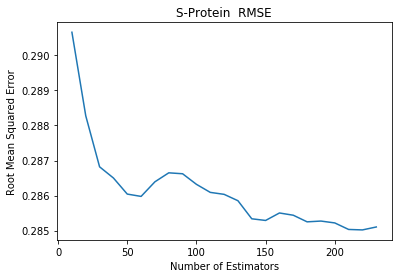

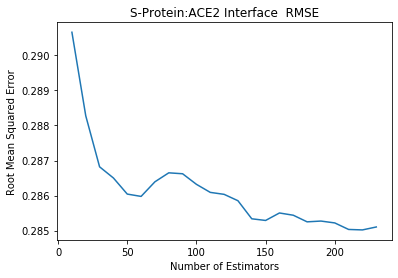

In [15]:
numEstimatorsPlot("S-Protein ", isolated_train_x, isolated_train_y, isolated_test_x, isolated_test_y)
numEstimatorsPlot("S-Protein:ACE2 Interface ", interface_train_x, interface_train_y, interface_test_x, interface_test_y)

After determining visully that the optimal number of estimators, which changes with each random generation of the training and test sets, I construct final RF models for each of them with this parameter.

In [16]:
# This function generates the random forest for a given protein with a given number of estimators
def generateRF(protein, trainX, trainY, testX, testY, n_estimators):
    regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    regressor.fit(trainX, trainY)
    y_pred = regressor.predict(testX)
    
    plots(regressor, y_pred, trainX, trainY, testX, testY, "RF", protein)
    return regressor

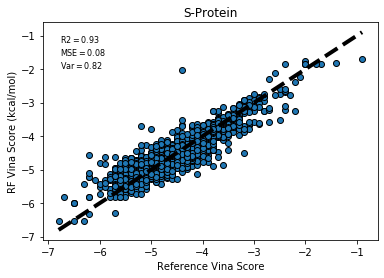

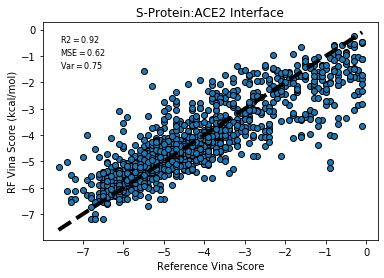

In [17]:
iso_regressor = generateRF("S-Protein", isolated_train_x, isolated_train_y, isolated_test_x, isolated_test_y, 150)
int_regressor = generateRF("S-Protein:ACE2 Interface", interface_train_x, interface_train_y, interface_test_x, interface_test_y, 150)

## Model 2: Gradient Boosting Regressor

In this section I created a function that automatically generates my gradient boosting regressor. It begins with a generating a GB fit with given parameters on the training data. I then compute the test and training set deviances as a function of boosting iterations and visualize the feature importance for both the S-Protein and the interface.

In [92]:
from sklearn.model_selection import GridSearchCV

# Generates and optimizes our model
def makeCLF(protein, trainX, trainY, testX, testY,X,y):
    # Checks through the given grid of parameters to find the most optimal
    param_grid = {'learning_rate': [0.1,0.05,0.02,0.01],
                 'max_depth': [4,6],
                 'min_samples_leaf': [3,5,9,17],
                 'max_features':[1.0,0.3,0.1],
                 'n_estimators':[200,500,700]}
    est = GradientBoostingRegressor(n_estimators=3000)
    gs_cv = GridSearchCV(est, param_grid).fit(X, y)
    gs_cv.best_params_
    clf = ensemble.GradientBoostingRegressor(**gs_cv.best_params_)

    clf.fit(trainX, trainY)
    mse = mean_squared_error(testY, clf.predict(testX))
    print("MSE: %.4f" % mse)

    # #############################################################################
    # Plot feature importance
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, col_names)
    plt.xlabel('Relative Importance')
    plt.title(protein + ' Variable Importance')
    plt.figure(figsize=(6,8))
    plt.show()
    
    # Use model to predict Vina scores for the test set, plot these predictions against the true values
    y_clf = clf.predict(testX)
    plots(clf, y_clf, trainX, trainY, testX, testY, "GB", protein)
    return feature_importance
    

MSE: 0.0745


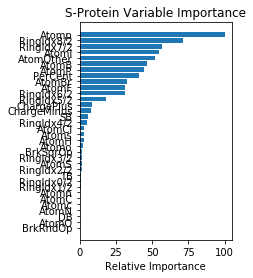

<Figure size 432x576 with 0 Axes>

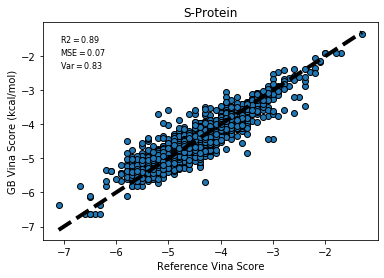

MSE: 0.5692


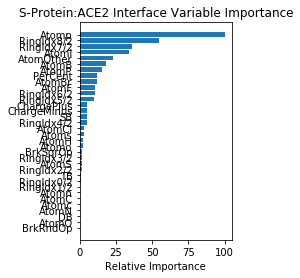

<Figure size 432x576 with 0 Axes>

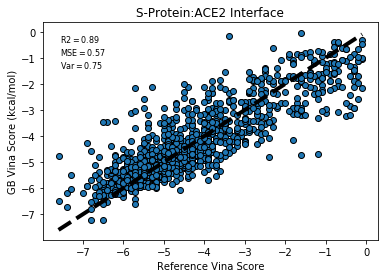

In [93]:
iso_import = makeCLF("S-Protein", isolated_train_x, isolated_train_y, isolated_test_x, isolated_test_y, isolated_X, isolated_Y)
int_import = makeCLF("S-Protein:ACE2 Interface", interface_train_x, interface_train_y, interface_test_x, interface_test_y, interface_X, interface_Y)

After running makeCLF a few times to try to make the feature importance charts more legible I recreated them below so that I could edit them more easily since the function above takes a long time to run.

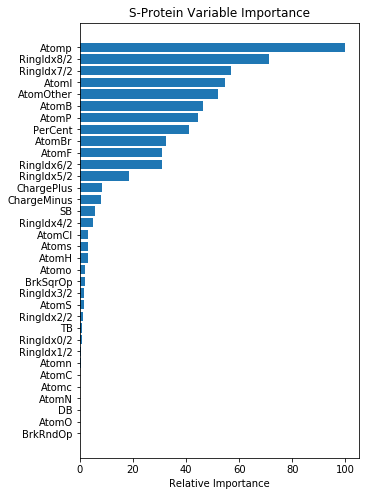

In [98]:
feature_importance = 100.0 * (iso_import / iso_import.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, col_names)
plt.xlabel('Relative Importance')
plt.title('S-Protein Variable Importance')
plt.gcf().set_size_inches(11,8)
plt.show()

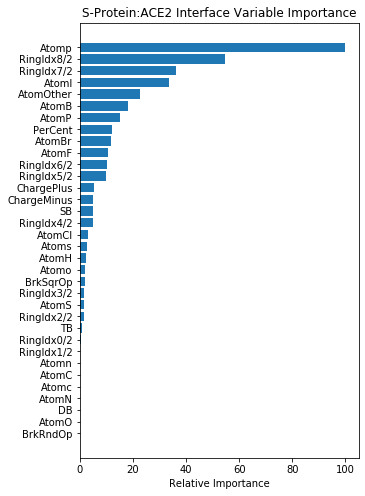

In [103]:
feature_importance = 100.0 * (int_import / int_import.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, col_names)
plt.xlabel('Relative Importance')
plt.title('S-Protein:ACE2 Interface Variable Importance')
plt.gcf().set_size_inches(11,8)
plt.show()

## Models 2&3: SVR AND KRR

In this section I generate both SVR and KRR models to predict the Vina scores. As with the section above, I generate and optimize both models using a grid search and, as with the model above, this method takes a little while to run.

In [100]:
import time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge


In [104]:
# Create and optimize the SVR and KRR models
def generateSVRandKR(protein, trainX, trainY, testX, testY):
    svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

    kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

    # List the time it takes to train and test the models
    t0 = time.time()
    svr.fit(trainX, trainY)
    svr_fit = time.time() - t0
    print("SVR complexity and bandwidth selected and model fitted in %.3f s"
          % svr_fit)

    t0 = time.time()
    kr.fit(trainX, trainY)
    kr_fit = time.time() - t0
    print("KRR complexity and bandwidth selected and model fitted in %.3f s"
          % kr_fit)

    sv_ratio = svr.best_estimator_.support_.shape[0] / len(trainX)
    print("Support vector ratio: %.3f" % sv_ratio)

    t0 = time.time()
    y_svr = svr.predict(testX)
    svr_predict = time.time() - t0
    print("SVR prediction for %d inputs in %.3f s"
          % (testX.shape[0], svr_predict))

    t0 = time.time()
    y_kr = kr.predict(testX)
    kr_predict = time.time() - t0
    print("KRR prediction for %d inputs in %.3f s"
          % (testX.shape[0], kr_predict))
    
    # Use models to predict Vina scores for the test set, plot these predictions against the true values
    plots(kr, y_kr, trainX, trainY, testX, testY, "KRR", protein)
    plots(svr, y_svr, trainX, trainY, testX, testY, "SVR", protein)
    

SVR complexity and bandwidth selected and model fitted in 445.631 s
KRR complexity and bandwidth selected and model fitted in 432.137 s
Support vector ratio: 0.679
SVR prediction for 2147 inputs in 0.400 s
KRR prediction for 2147 inputs in 0.155 s


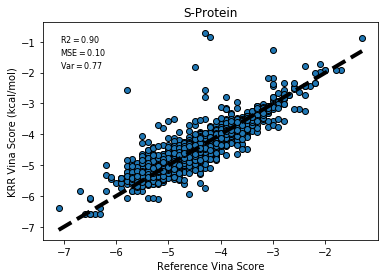

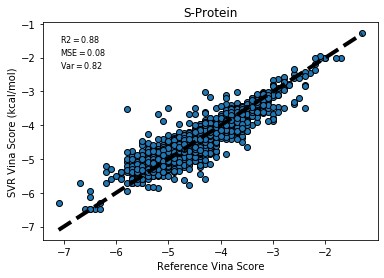

SVR complexity and bandwidth selected and model fitted in 203.953 s
KRR complexity and bandwidth selected and model fitted in 176.636 s
Support vector ratio: 0.804
SVR prediction for 1407 inputs in 0.202 s
KRR prediction for 1407 inputs in 0.046 s


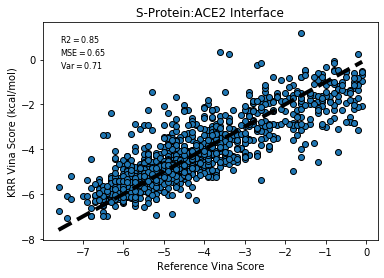

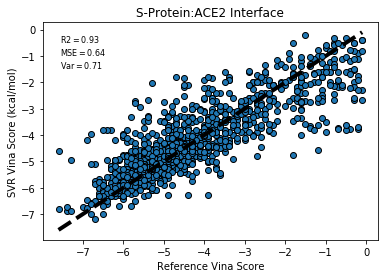

In [105]:
generateSVRandKR("S-Protein", isolated_train_x, isolated_train_y, isolated_test_x, isolated_test_y)
generateSVRandKR("S-Protein:ACE2 Interface", interface_train_x, interface_train_y, interface_test_x, interface_test_y)

## Stacking

This uses a stacking function built into scikit learn which generates its own RF, SVR, GB, and RF-SVR-GB stacked models, and generates plots comparing each model.

In [65]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeCV
import time
import numpy as np
from sklearn.model_selection import cross_validate, cross_val_predict


# Choose the models for the stacked regressor
estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('SVR', SVR()),
    ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))
]
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV()
)

In [66]:
# Plot the results of the stacked model
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

In [67]:
# Generate the stacked model
def stackedModel(protein, trainX, trainY, testX, testY):
    fig, axs = plt.subplots(2, 2, figsize=(9, 7))
    axs = np.ravel(axs)

    for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                                   stacking_regressor)]):
        start_time = time.time()
        score = cross_validate(est, trainX, trainY,
                               scoring=['r2', 'neg_mean_absolute_error'],
                               n_jobs=-1, verbose=0)
        elapsed_time = time.time() - start_time

        y_pred = cross_val_predict(est, testX, testY, n_jobs=-1, verbose=0)
        plot_regression_results(
            ax, testY, y_pred,
            name,
            (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
            .format(np.mean(score['test_r2']),
                    np.std(score['test_r2']),
                    -np.mean(score['test_neg_mean_absolute_error']),
                    np.std(score['test_neg_mean_absolute_error'])),
            elapsed_time)

    plt.suptitle(protein + ' Single predictors versus stacked predictors')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

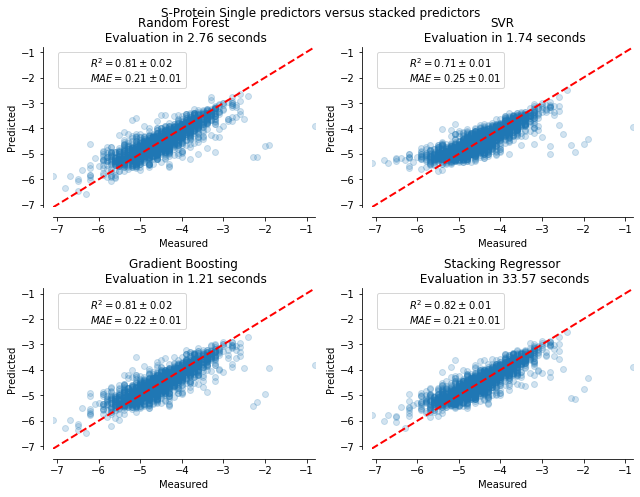

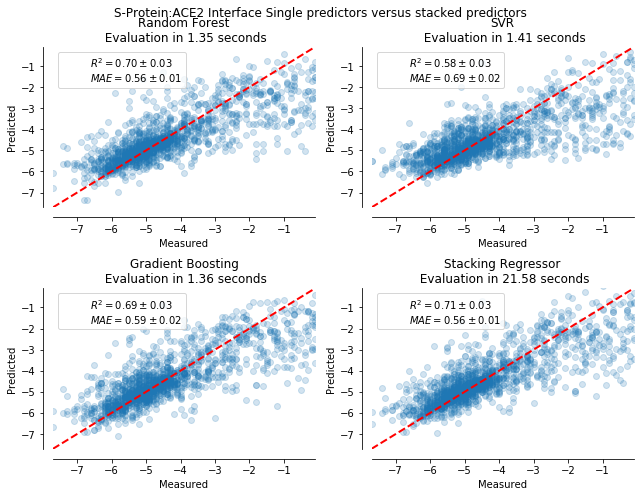

In [68]:
stackedModel("S-Protein", isolated_train_x, isolated_train_y, isolated_test_x, isolated_test_y)
stackedModel("S-Protein:ACE2 Interface", interface_train_x, interface_train_y, interface_test_x, interface_test_y)

## Screening FDA Approved and Other Ligands

Now that we have found the best model for screening, the RF model created above, we are going to use this model to predict the Vina scores of ligands in the CureFFI and the DrugCentral dataset. We will then screen out those with the lowest Vina scores and compare this set to Batra's.

In [220]:
# Read in the CureFFI and DrugCentral datasets
df_cureffi = pd.read_csv(path + 'drugs.txt',sep="	")
df_drugcentral = pd.read_csv(path + 'drugcentral.tsv',sep="	")

In [221]:
# Drop empty columns,add the fingerprint columns, add the Vina predictions
def clean(df, smiles, numcols):
    df = df.dropna()
    df = df.rename(columns={smiles: "smiles"})
    df['fingerprint'] = df.apply(lambda row: getSMIfp(row.smiles), axis = 1)
    col_names = ["BrkRndOp","AtomO","DB","AtomN","Atomc","AtomC","Atomn","RingIdx1/2","RingIdx0/2","TB",
             "RingIdx2/2","AtomS","RingIdx3/2","BrkSqrOp","Atomo","AtomH","Atoms","AtomCl","RingIdx4/2","SB",
             "ChargeMinus","ChargePlus","RingIdx5/2","RingIdx6/2","AtomF","AtomBr","PerCent","AtomP","AtomB","AtomOther",
             "AtomI","RingIdx7/2","RingIdx8/2","Atomp"]
    df_X = pd.DataFrame(df['fingerprint'].to_list(), columns=col_names)
    df = pd.concat([df, df_X], axis=1)
    df = df.dropna()
    X = df.iloc[:, numcols+1:]
    iso_ml = iso_regressor.predict(X)
    int_ml = int_regressor.predict(X)
    df['VinaInterface'] = int_ml
    df['VinaIsolated'] = iso_ml
    return df

In [222]:
df_cureffi = clean(df_cureffi,"smiles",3)
df_drugcentral = clean(df_drugcentral,"SMILES",6)

In [223]:
df_cureffi.head()

,generic_name,cns_drug,smiles,fingerprint,BrkRndOp,AtomO,DB,AtomN,Atomc,AtomC,...,PerCent,AtomP,AtomB,AtomOther,AtomI,RingIdx7/2,RingIdx8/2,Atomp,VinaInterface,VinaIsolated
0,Abacavir,False,NC1=NC2=C(N=CN2[C@@H]2C[C@H](CO)C=C2)C(NC2CC2)=N1,"[3, 1, 5, 6, 0, 14, 0, 3, 1, 0, 0, 0, 0, 2, 0,...",3.0,1.0,5.0,6.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.199918,-4.546765
4,Abiraterone,False,CC(=O)O[C@H]1CC[C@]2(C)C3CC[C@@]4(C)C(CC=C4C4=...,"[4, 2, 6, 1, 0, 26, 0, 1, 1, 0, 1, 0, 2, 3, 0,...",6.0,4.0,5.0,2.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.584091,-4.024500
5,Acamprosate,True,CC(=O)NCCCS(O)(=O)=O,"[3, 4, 3, 1, 0, 5, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",5.0,6.0,10.0,1.0,0.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.131925,-4.550000
6,Acarbose,False,C[C@H]1O[C@H](O[C@@H]2[C@@H](CO)O[C@H](O[C@@H]...,"[12, 18, 1, 1, 0, 25, 0, 1, 2, 0, 1, 0, 0, 19,...",3.0,1.0,7.0,2.0,0.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.625051,-4.423097
7,Acebutolol,False,CCCC(=O)NC1=CC(C(C)=O)=C(OCC(O)CNC(C)C)C=C1,"[6, 4, 5, 2, 0, 18, 0, 0, 1, 0, 0, 0, 0, 0, 0,...",4.0,1.0,7.0,2.0,0.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.637273,-4.491981


In [224]:
# Plot the vina scores with Batra's cut and my cut, then add those that pass the cut to a new dataframe
def makeVinaCuts(df, name):
    fig, ax = plt.subplots()
    ax.scatter(df["VinaInterface"], df["VinaIsolated"], edgecolors=(0, 0, 0))
    y1 = -(1/2)*x-7.5
    ax.plot(x, y1, 'k--', label = 'Batra Screening Cut', lw=1)
    y2 = -(1/2)*x-7.3
    ax.plot(x, y2, 'b--', label = 'My Screening Cut', lw=1)
    plt.xlim(-7, 0)
    plt.ylim(-6, -1)
    ax.legend(loc='upper left')
    ax.set_xlabel('Interface Vina Score (RF pred.)')
    ax.set_ylabel('S-Protein Vina Score (RF pred.)')
    ax.set_title(name + " Vina Score Predictions")
    plt.gcf().set_size_inches(5,5)
    plt.show()
    
    df_batra_candidates = df[df['VinaIsolated'] < (-(1/2)*df['VinaInterface']-7.5)]
    df_candidates = df[df['VinaIsolated'] < (-(1/2)*df['VinaInterface']-7.3)]
    return df_batra_candidates, df_candidates

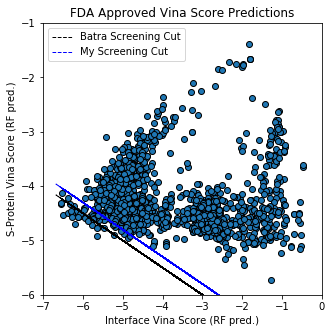

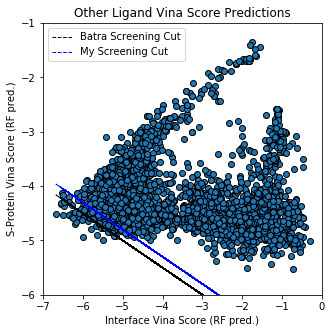

In [225]:
df_cure_batra_cut_candidates, df_cure_candidates = makeVinaCuts(df_cureffi, "FDA Approved")
df_drug_batra_cut_candidates, df_drug_candidates = makeVinaCuts(df_drugcentral, "Other Ligand")

In [226]:
df_drug_batra = pd.read_excel(path + 'DrugCentral_top_candidates.xlsx')
df_cure_batra = pd.read_excel(path + 'FDA_Aprroved_top_candidates.xlsx') 

In [200]:
df_drug_batra.head()

,ID,canonical_smiles,Score_interface,pred_ML_interface,Score_sprotein,pred_ML_sprotein,SmithDuplicate,Source
0,15,NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]cn1)NC(=O...,-7.7,-6.533069,-4.9,-4.669608,0,drugcentral
1,89,O=C(O)C(=O)Nc1cccc(-c2nnn[nH]2)c1,-7.6,-6.219817,-5,-4.581275,0,drugcentral
2,210,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,-7.4,-6.722303,-4.6,-4.184931,0,drugcentral
3,219,Cc1cnc(NS(=O)(=O)c2ccc(N)cc2)nc1,-7.2,-5.987288,-4.8,-4.539954,0,drugcentral
4,134,O=C(O)CCC(=O)Nc1ccc(S(=O)(=O)Nc2nccs2)cc1,-7.2,-6.136197,-4.4,-4.547329,0,drugcentral


In [201]:
df_cure_batra.head()

,ID,GeneralName,canonical_smiles,Score_interface,pred_ML_interface,Score_sprotein,pred_ML_sprotein,SmithDuplicate,Source
0,152,Pemirolast,Cc1cccn2c(=O)c(-c3nn[nH]n3)cnc12,-7.3,-6.074002,-5.0,-4.563910,0,cureffi
1,207,Sulfamethoxazole,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-7.2,-6.118972,-4.7,-4.491054,0,cureffi
2,165,Valaciclovir,CC(C)[C@H](N)C(=O)OCCOCn1cnc2c(=O)nc(N)[nH]c21,-7.2,-6.146023,-4.3,-4.512975,0,cureffi
3,193,Sulfamerazine,Cc1ccnc(NS(=O)(=O)c2ccc(N)cc2)n1,-7.1,-5.984288,-4.8,-4.573446,0,cureffi
4,62,Tazobactam,C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(...,-7.0,-5.715304,-4.8,-4.883713,0,cureffi


In [212]:
df_cure_candidates.head()

,generic_name,cns_drug,smiles,fingerprint,BrkRndOp,AtomO,DB,AtomN,Atomc,AtomC,...,PerCent,AtomP,AtomB,AtomOther,AtomI,RingIdx7/2,RingIdx8/2,Atomp,VinaInterface,VinaIsolated
9,Acepromazine,False,CN(C)CCCN1C2=CC=CC=C2SC2=C1C=C(C=C2)C(C)=O,"[3, 1, 7, 2, 0, 19, 0, 2, 1, 0, 0, 1, 0, 0, 0,...",4.0,3.0,5.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.544911,-4.332667
19,Acetylsalicylic acid,False,CC(=O)OC1=CC=CC=C1C(O)=O,"[2, 4, 5, 0, 0, 9, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",3.0,3.0,4.0,5.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.373643,-4.228398
24,Adapalene,False,COC1=C(C=C(C=C1)C1=CC2=C(C=C1)C=C(C=C2)C(O)=O)...,"[7, 3, 9, 0, 0, 28, 0, 2, 3, 0, 1, 0, 0, 0, 0,...",5.0,7.0,5.0,5.0,0.0,10.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.976546,-4.873905
121,Arbekacin,False,NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]...,"[9, 10, 1, 6, 0, 22, 0, 1, 2, 0, 0, 0, 0, 14, ...",4.0,5.0,3.0,4.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.120857,-4.565176
233,Butorphanol,True,[H][C@@]12CC3=C(C=C(O)C=C3)[C@]3(CCCC[C@@]13O)...,"[3, 2, 3, 1, 0, 21, 0, 1, 2, 0, 2, 0, 0, 4, 0,...",6.0,6.0,5.0,3.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.810186,-4.552122


In [213]:
df_drug_candidates.head()

,smiles,InChI,InChIKey,ID,INN,CAS_RN,fingerprint,BrkRndOp,AtomO,DB,...,PerCent,AtomP,AtomB,AtomOther,AtomI,RingIdx7/2,RingIdx8/2,Atomp,VinaInterface,VinaIsolated
7,NC1=NC(=O)N(C=N1)[C@@H]1O[C@H](CO)[C@@H](O)[C@...,InChI=1S/C8H12N4O5/c9-7-10-2-12(8(16)11-7)6-5(...,NMUSYJAQQFHJEW-KVTDHHQDSA-N,25,azacitidine,320-67-2,"[4, 5, 3, 4, 0, 8, 0, 0, 2, 0, 0, 0, 0, 4, 0, ...",4,5,3,...,0,0,0,0,0,0,0,0,-6.120857,-4.565176
9,CC(=O)OC[C@H]1O[C@H]([C@H](OC(C)=O)[C@@H]1OC(C...,InChI=1S/C14H17N3O9/c1-6(18)23-5-9-11(24-7(2)1...,QQOBRRFOVWGIMD-OJAKKHQRSA-N,27,azaribine,2169-64-4,"[6, 9, 6, 3, 0, 14, 0, 0, 2, 0, 0, 0, 0, 4, 0,...",6,9,6,...,0,0,0,0,0,0,0,0,-5.341076,-4.853322
10,COC1=C2OC=CC2=CC2=C1OC(=O)C=C2,InChI=1S/C12H8O4/c1-14-12-10-8(4-5-15-10)6-7-2...,QXKHYNVANLEOEG-UHFFFAOYSA-N,30,methoxsalen,298-81-7,"[1, 4, 6, 0, 0, 12, 0, 2, 1, 0, 0, 0, 0, 0, 0,...",1,4,6,...,0,0,0,0,0,0,0,0,-5.249169,-4.714746
14,NC(=O)C1=C(N)N(C=N1)[C@@H]1O[C@H](CO)[C@@H](O)...,InChI=1S/C9H14N4O5/c10-7-4(8(11)17)12-2-13(7)9...,RTRQQBHATOEIAF-UUOKFMHZSA-N,37,acadesine,2627-69-2,"[5, 5, 3, 4, 0, 9, 0, 0, 2, 0, 0, 0, 0, 4, 0, ...",5,5,3,...,0,0,0,0,0,0,0,0,-6.151014,-4.629716
25,CN1C2=C(N(CC(O)=O)C=N2)C(=O)N(C)C1=O,InChI=1S/C9H10N4O4/c1-11-7-6(8(16)12(2)9(11)17...,HCYFGRCYSCXKNQ-UHFFFAOYSA-N,49,acefylline,652-37-9,"[5, 4, 5, 4, 0, 9, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",5,4,5,...,0,0,0,0,0,0,0,0,-5.989700,-4.481388


In [232]:
# Generate a table of the top candidates from the CureFFI dataset
df_cure_top_sorted = df_cure_candidates.sort_values(by ='VinaInterface' )
df_cure_top_sorted = df_cure_top_sorted[["generic_name","VinaInterface","VinaIsolated"]]
df_cure_top_sorted.columns = ["General Name","Interface Vina Score","S-protein Vina Score"]
df_cure_top_sorted = df_cure_top_sorted.reset_index(drop=True)
df_cure_top_sorted.index = np.arange(1,len(df_cure_top_sorted)+1)
df_cure_top_sorted[0:5]

,General Name,Interface Vina Score,S-protein Vina Score
1,L-Phenylalanine,-6.553244,-4.307389
2,Acepromazine,-6.544911,-4.332667
3,Metformin,-6.516587,-4.129286
4,Dacarbazine,-6.486117,-4.523879
5,Acetylsalicylic acid,-6.373643,-4.228398


In [233]:
# Generate a table of the top candidates from the DrugCentral dataset
df_drug_top_sorted = df_drug_candidates.sort_values(by ='VinaInterface' )
df_drug_top_sorted = df_drug_top_sorted[["INN","VinaInterface","VinaIsolated"]]
df_drug_top_sorted.columns = ["General Name","Interface Vina Score","S-protein Vina Score"]
df_drug_top_sorted = df_drug_top_sorted.reset_index(drop=True)
df_drug_top_sorted.index = np.arange(1,len(df_drug_top_sorted)+1)
df_drug_top_sorted[0:5]

,General Name,Interface Vina Score,S-protein Vina Score
1,sapropterin,-6.671810,-4.520089
2,methazolamide,-6.553244,-4.307389
3,acetazolamide,-6.544911,-4.332667
4,nitrofurazone,-6.516587,-4.129286
5,allantoin,-6.490978,-4.156611
